In [1]:
from functools import partial
from datasets import load_dataset
import torch
import torch.nn as nn
import numpy as np
import os
from collections import Counter
from conllu import parse_incr
import matplotlib.pyplot as plt

C:\Users\roven\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load the dataset to be used for calculating the statistics

full_dataloader = load_dataset('universal_dependencies', 'tr_imst', split='train')

Found cached dataset universal_dependencies (C:/Users/roven/.cache/huggingface/datasets/universal_dependencies/tr_imst/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)


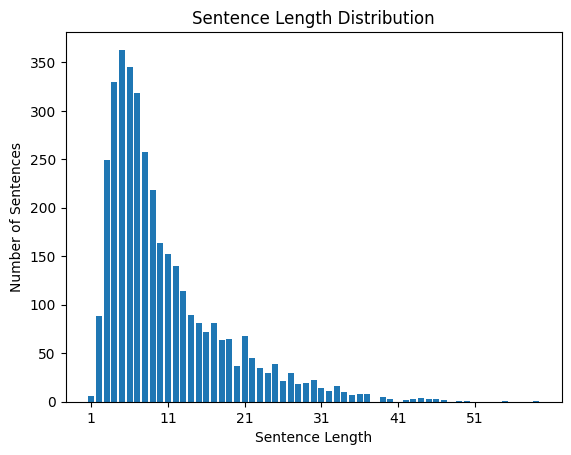

In [3]:
sentence_lengths = Counter()

for sentence in full_dataloader:
    tokens = sentence['tokens']
    length_each_sen = len(tokens)
    sentence_lengths[length_each_sen] += 1

# Extract the lengths and counts for plotting
lengths = list(sentence_lengths.keys())
counts = list(sentence_lengths.values())

# Rescale the graph with step size of 10
x_ticks = np.arange(min(lengths), max(lengths)+1, 10)

# Plot the bar graph
plt.bar(lengths, counts)
plt.xticks(x_ticks)
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.title('Sentence Length Distribution')
plt.show()

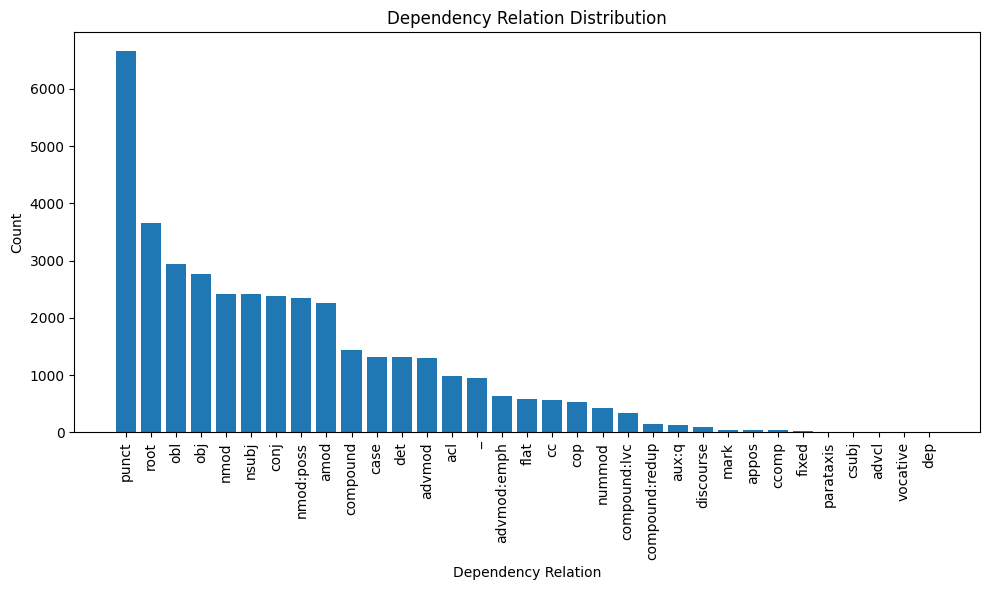

In [4]:
# Compute the distribution of dependency relations
dep_rel_counts = Counter()

for sentence in full_dataloader:
    dep_rels = sentence['deprel']
    dep_rel_counts.update(dep_rels)

# Sort the dependency relations and their counts in descending order
sorted_dep_rels, sorted_counts = zip(*sorted(dep_rel_counts.items(), key=lambda x: x[1], reverse=True))

# Plot the bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(sorted_dep_rels, sorted_counts)
plt.xlabel('Dependency Relation')
plt.ylabel('Count')
plt.title('Dependency Relation Distribution')
plt.xticks(rotation=90)
plt.tight_layout()  # Improve spacing between bars and labels

# Add labels to the bars
# for i, count in enumerate(sorted_counts):
    # plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [5]:
class ArcEager:
    def __init__(self, sentence):

        # sentence is the input for which we want to build our Arc-Eager parser
        # it is a list of words
        

        self.sentence = sentence  
        # initialize the buffer with the indexes of the words in the sentence
        self.buffer = [i for i in range(len(self.sentence))] 
        # initialize the stack empty 
        self.stack = []
        # representation of the tree
        # every word will have a -1 assigned -> no father has been assigned yet
        self.arcs = [-1 for _ in range(len(self.sentence))]  
        # means that in the stack now is the ROOT
        self.shift() 
        


    def shift(self):
      """ 
      Performs the shift operation, moving a word from the buffer to the stack. 
      """
      if len(self.buffer) > 0:
        b1 = self.buffer[0]
        self.buffer = self.buffer[1:]
        self.stack.append(b1)
    
    def left_arc(self): 
      """ 
      Performs the left arc operation, 
      adding an arc from the second item in the stack to the first item in the stack   
      """
  
     # if self.stack[-1] !=0 and self.arcs[self.stack[-1]]==-1:
     
      s1 = self.stack.pop()
      b1 = self.buffer[0]
      self.arcs[s1] = b1
      # self.stack.append(b1)
      # if len(self.stack)<2 and len(self.buffer)>0:
        # self.shift()


 
    def right_arc(self):
     """
      Performs the right arc operation,
      adding an arc from the first item in the stack to the first item in the buffer
     """
     b1 = self.buffer[0]
     s1 = self.stack[-1]
     self.arcs[b1] = s1
     self.stack.append(b1)
     self.buffer = self.buffer[1:]
     # if len(self.stack)<2 and len(self.buffer)>0:
        # self.shift()

    def reduce(self):
     """
      Performs the reduce operation, removing the first item from the stack
     """
     self.stack.pop()

    
    def is_tree_final(self):
      """
      Checks if the tree is final, i.e. if the buffer is empty and the stack contains only one item
      """
      return len(self.stack) == 1 and len(self.buffer) == 0
     

    def print_configuration(self):
      """
      Prints the current configuration of the parser
      """

      s = [self.sentence[i] for i in self.stack]
      b = [self.sentence[i] for i in self.buffer]
      print(s,b)
      print(self.arcs)
    
      

In [ ]:
sentence = ["<ROOT>", "book","the","flight","through","houston"]
gold = [-1, 0, 3, 1, 5, 3]

parser = ArcEager(sentence)
parser.print_configuration()

In [ ]:
parser.right_arc()
parser.print_configuration()

In [ ]:
parser.shift()
parser.print_configuration()

In [ ]:
parser.left_arc()
parser.print_configuration()


In [ ]:
parser.right_arc()
parser.print_configuration()

In [ ]:
parser.reduce()
parser.print_configuration()

In [ ]:
parser.reduce()
parser.print_configuration()

In [ ]:
parser.reduce()
parser.print_configuration()

In [12]:
class Oracle:
  """
  Oracle class that implements the oracle for the arc-eager transition system
  
  Args:
    parser (ArcEager): the parser
    gold_tree (list): the gold tree
    
  """
  def __init__(self, parser, gold_tree):
    
    self.parser = parser
    self.gold = gold_tree
  
  def has_head(self, stack_top):
    return  self.parser.arcs[stack_top] != -1 
  
  def has_all_children(self, stack_top):
    i = 0
    for arc in self.gold:
      if arc == stack_top:
        if self.parser.arcs[i] != stack_top:
          return False
      i+=1
    return True
  
  def GoldAction(self):

     if len(self.parser.buffer) > 0 and self.parser.stack[-1] != 0 and self.gold[self.parser.stack[-1]] == self.parser.buffer[0]:
       return 'LEFT-ARC'
     elif  len (self.parser.buffer) > 0  and self.gold[self.parser.buffer[0]] == self.parser.stack[-1]:
       return 'RIGHT-ARC'
     elif self.has_all_children(self.parser.stack[-1]) and self.has_head(self.parser.stack[-1]) and len(self.parser.stack) > 1:
       return 'REDUCE'
     else:
        return 'SHIFT'


  def can_left_arc(self):
    if  self.parser.stack[-1] != 0 and not self.has_head(self.parser.stack[-1]):
      return True
    return False  

  def can_reduce(self):
    if  self.has_head(self.parser.stack[-1]):
      return True
    return False


In [13]:
sentence = ["<ROOT>", "book","the","flight","through","houston"]
gold = [-1, 0, 3, 1, 5, 3]

parser = ArcEager(sentence)

parser.print_configuration()

['<ROOT>'] ['book', 'the', 'flight', 'through', 'houston']
[-1, -1, -1, -1, -1, -1]


In [20]:
# sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
# gold = [-1, 2, 0, 4, 2, 4, 2 ]

sentence = [ '<ROOT>',"this", "mode", "conform", "closely", "to", "the", "ANSI-92", "level", "1", "specification", ",", "but", "be", "not", "ANSI-92", "level", "1", "compliant", "." ]
gold = [-1, 2, 3, 0, 3, 10, 10, 10, 10, 8, 3, 18, 18, 18, 18, 18, 18, 16, 3, 3] 
parser = ArcEager(sentence)
oracle = Oracle(parser, gold)

while not parser.is_tree_final():
    if oracle.GoldAction() == "RIGHT-ARC":
        parser.right_arc()
    elif oracle.GoldAction() == "LEFT-ARC" and oracle.can_left_arc() :
        parser.left_arc()
    elif oracle.GoldAction() == "REDUCE" and oracle.can_reduce():
        parser.reduce()
    else:
        parser.shift()

        
print(parser.arcs)
print(gold)
    

[-1, 2, 3, 0, 3, 10, 10, 10, 10, 8, 3, 18, 18, 18, 18, 18, 18, 16, 3, 3]
[-1, 2, 3, 0, 3, 10, 10, 10, 10, 8, 3, 18, 18, 18, 18, 18, 18, 16, 3, 3]


In [21]:
def is_projective(tree):
    """
    Checks if a tree is projective or not
    """
    for i in range(len(tree)):
        if tree[i]==-1:
            continue
        left = min(i, tree[i])
        right = max(i, tree[i])

        for j in range(0, left):
            if tree[j] > left and tree[j] < right:
                return False
        for j in range(left+1, right):
            if tree[j] < left or tree[j] > right:
                return False
        for j in range(right+1, len(tree)):
            if tree[j] > left  and tree[j] < right:
                return False
    return True


In [22]:
def create_dict(dataset, threshold = 3):

    """ ceate a dictionary of words with frequency >= threshold
    """
    
    dic = {}

    for sample in dataset:
        for word in sample['tokens']:
            if word in dic:
                dic[word] += 1
            else:
                dic[word] = 1
    
    map = {}
    map["<pad>"] = 0
    map["<ROOT>"] = 1
    map["<unk>"] = 2

    next_indx = 3
    for word in dic.keys():
        if dic[word] >= threshold:
            map[word] = next_indx
            next_indx += 1
    return map

In [66]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'train')
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'validation')
test_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'test')

# remove non-projective sentences: heads in the gold 
# tree are strings, we convert them to int

train_dataset =[sample for sample in train_dataset if is_projective([-1] + [int(head) for head in sample['head']])]

# create embedding dictionary

emb_dictionary = create_dict(train_dataset)


print("Number of samples:")
print("Train:\t", len(train_dataset))
print("Dev:\t", len(dev_dataset))
print("Test:\t", len(test_dataset))

Found cached dataset universal_dependencies (C:/Users/roven/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)
Found cached dataset universal_dependencies (C:/Users/roven/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)
Found cached dataset universal_dependencies (C:/Users/roven/.cache/huggingface/datasets/universal_dependencies/en_lines/2.7.0/1ac001f0e8a0021f19388e810c94599f3ac13cc45d6b5b8c69f7847b2188bdf7)


Number of samples:
Train:	 2922
Dev:	 1032
Test:	 1035


In [67]:
def process_sample(sample:dict, get_gold_path = False):
  """
  Process one sample from the dataset
  Args:
    sample (dict): sample from the dataset
    get_gold_path (bool): whether to get gold path for training
  Returns:
    enc_sentence (list): list of word ids
    gold_path (list): list of configurations
    gold_moves (list): list of oracle moves
  """
  

  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  
  
  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   
  gold_moves = []  

  if get_gold_path:  
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      
      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])  
      gold_path.append(configuration)

      # save gold move
      if oracle.GoldAction() == "LEFT-ARC":
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.GoldAction() == "RIGHT-ARC":
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.GoldAction() == "REDUCE":
        parser.reduce()
        gold_moves.append(3)
      else:
        parser.shift()
        gold_moves.append(2)

  return enc_sentence, gold_path, gold_moves, gold

    


The prepare_batch function processes a batch of data by applying the process_sample function to each sample and extracts the necessary information to separate lists for sentences, paths, moves, and trees.

In [68]:
def prepare_batch(batch_data, get_gold_path = False):
    """
    Prepare batch for training
    Args:
      batch_data (list): list of samples from the dataset
      get_gold_path (bool): whether to get gold path for training
    Returns:
        sentences (list): list of word ids
        paths (list): list of configurations
        moves (list): list of oracle moves
        trees (list): list of gold trees
    """
    data = [process_sample(s, get_gold_path = get_gold_path) for s in batch_data]

    sentences = [s[0] for s in data]
    paths = [s[1] for s in data]
    moves = [s[2] for s in data]
    trees = [s[3] for s in data]

    return sentences, paths, moves, trees

Here we set up data loaders for training, development, and testing datasets with a batch size of 32. Additionally, we define the hyperparameters for the neural network, showing the values that yield the best results. 

In [69]:
BATCH_SIZE = 20

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch, get_gold_path = True))
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch))

In [70]:
# define hyperparameters of NN
EMBEDDING_SIZE = 300
LSTM_SIZE = 300
LSTM_LAYERS = 2
MLP_SIZE = 300
DROPOUT = 0.2
EPOCHS = 2
LR = 0.001

After preparing the data, we will give the sentence to BiLSTM to obtain some contextual representation and then we will use Feed-Forward to score the parser configuration and what is the best transition to do next.




In [71]:
class Net(nn.Module):

  def __init__(self, device):
    super(Net, self).__init__()
    self.device = device
    self.embeddings = nn.Embedding(len(emb_dictionary), EMBEDDING_SIZE, padding_idx=emb_dictionary["<pad>"])

    # initialize bi-LSTM
    self.lstm = nn.LSTM(EMBEDDING_SIZE, LSTM_SIZE, num_layers = LSTM_LAYERS, bidirectional=True, dropout=DROPOUT)

    # initialize feedforward
    self.w1 = torch.nn.Linear(6*LSTM_SIZE, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    self.dropout = torch.nn.Dropout(DROPOUT)


  def forward(self, x, paths):
    # get the embeddings
    x = [self.dropout(self.embeddings(torch.tensor(i).to(self.device))) for i in x]

    # run the bi-lstm
    h = self.lstm_pass(x)

    # for each parser configuration that we need to score we arrange from the
    # output of the bi-lstm the correct input for the feedforward
    mlp_input = self.get_mlp_input(paths, h)

    # run the feedforward and get the scores for each possible action
    out = self.mlp(mlp_input)

    return out

  def lstm_pass(self, x):
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h) # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    mlp_input = []
    zero_tensor = torch.zeros(2*LSTM_SIZE, requires_grad=False).to(self.device)
    for i in range(len(configurations)): # for every sentence in the batch
      for j in configurations[i]: # for each configuration of a sentence
        mlp_input.append(torch.cat([zero_tensor if j[0]==-1 else h[j[0]][i], zero_tensor if j[1]==-1 else h[j[1]][i], zero_tensor if j[2]==-1 else h[j[2]][i]]))
    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  # we use this function at inference time. We run the parser and at each step
  # we pick as next move the one with the highest score assigned by the model
  def infere(self, x):

    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  # In this function we select and perform the next move according to the scores obtained.
  # We need to be careful and select correct moves, e.g. don't do a shift if the buffer
  # is empty or a left arc if σ2 is the ROOT. For clarity sake we didn't implement
  # these checks in the parser so we must do them here. This renders the function quite ugly
  def parse_step(self, parsers, moves):
      moves_argm = moves.argmax(-1)
      for i in range(len(parsers)):
          if parsers[i].is_tree_final():
              continue
          else:
              # Left arc
              if moves_argm[i] == 0:
                  stack_len = len(parsers[i].stack)
                  if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                      parsers[i].left_arc()
                  else:
                    if len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    elif len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                    else:
                      parsers[i].shift()

              # Right arc
              elif moves_argm[i] == 1:
                  stack_len = len(parsers[i].stack)
                  if stack_len >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                  else:
                      if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                      elif len(parsers[i].stack) >= 2:
                        parsers[i].reduce()
                      else:
                        parsers[i].shift()

              # Shift
              elif moves_argm[i] == 2:
                  if len(parsers[i].buffer) > 0:
                      parsers[i].shift()
                  else:
                    if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                    elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    elif len(parsers[i].stack) >= 2:
                      parsers[i].reduce()

              # Reduce
              elif moves_argm[i] == 3:
                  if len(parsers[i].stack) >= 2:
                      parsers[i].reduce()
                  else:
                    if parsers[i].stack[-1] != 0 and len(parsers[i].buffer) > 0:
                        parsers[i].left_arc()
                    elif len(parsers[i].stack) >= 2 and len(parsers[i].buffer) > 0:
                      parsers[i].right_arc()
                    else:
                      parsers[i].shift()

In [72]:
# Evaluation
def evaluate(gold, preds):
 """Evaluate the model performance on the test set."""	

 total = 0
 correct = 0

 for g, p in zip(gold, preds):
  for i in range(1,len(g)):
    total += 1
    if g[i] == p[i]:
     correct += 1

 return correct/total

# Training
def train(model, dataloader, criterion, optimizer):

  """Train the model on the training set."""	

  model.train()
  total_loss = 0
  count = 0

  for batch in dataloader:
    """Train the model on the training set."""

    optimizer.zero_grad()
    sentences, paths, moves, trees = batch

    out = model(sentences, paths)
    labels = torch.tensor(sum(moves, [])).to(device) #sum(moves, []) flatten the array
    loss = criterion(out, labels)

    count +=1
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss/count

# Testing
def test(model, dataloader):
  """Evaluate the model performance on the test set."""
  model.eval()

  gold = []
  preds = []

  for batch in dataloader:
    sentences, paths, moves, trees = batch
    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Net(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train(model, train_dataloader, criterion, optimizer)
  val_uas = test(model, dev_dataloader)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))

Device: cpu
Epoch:   0 | avg_train_loss: 0.991 | dev_uas: 0.581 |
Epoch:   1 | avg_train_loss: 0.904 | dev_uas: 0.620 |


In [ ]:
test_uas = test(model, test_dataloader)
print("test_uas: {:5.3f}".format(test_uas))

In [ ]:
train_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'train')
dev_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'validation')
test_dataset = load_dataset('universal_dependencies', 'en_lines', split = 'test')


In [ ]:
#@title Util function for tokenization
def map_tokenize (example):

    example['head'] = []
    example['tokens'] = []
    for index, elem in enumerate(example['head']):
      if elem != 'None':
        example['head'].append(elem)
        example['tokens'].append(example['tokens'][index])

    tokens = example["tokens"]
    heads = example["head"]

    # Tokenize the tokens using BERT tokenizer
    tokenized_inputs = tokenizer(tokens, truncation=True, is_split_into_words=True, padding='max_length')
    input_ids = tokenized_inputs['input_ids']
    attention_mask = tokenized_inputs['attention_mask']
    word_ids = tokenized_inputs.word_ids()

    # Return the transformed sample
    sample = {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'word_ids' : word_ids, 
        'tokens': tokens,
        'head': heads
    }

    return sample

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")

train_dataset = train_dataset.map(map_tokenize)
dev_dataset = dev_dataset.map(map_tokenize)
test_dataset = test_dataset.map(map_tokenize)

In [ ]:
def process_sample_bert(sample, get_gold_path =  False):
  # put sentence and gold tree in our format
  sentence = ["<ROOT>"] + sample["tokens"]
  gold = [-1] + [int(i) for i in sample["head"]]  
  
  # embedding ids of sentence words
  enc_sentence = [emb_dictionary[word] if word in emb_dictionary else emb_dictionary["<unk>"] for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  gold_path = []   
  gold_moves = []  

  if get_gold_path:  
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():
      
      # save configuration
      configuration = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
      if len(parser.buffer) == 0:
        configuration.append(-1)
      else:
        configuration.append(parser.buffer[0])  
      gold_path.append(configuration)

      # save gold move
      if oracle.is_left_arc_gold(): 
        gold_moves.append(0)
        parser.left_arc()
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(1)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(2)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(3)
        
  connector = []
  connector.append(1)
  for i, word in enumerate(sample["tokens"]):
    connector.append(sample["word_ids"].index(i))
  return enc_sentence, gold_path, gold_moves, gold, sample["input_ids"], connector, sample["attention_mask"]

In [ ]:
def prepare_batch_bert(batch_data, get_gold_path=False):
  """Prepare the batch for the model.

  :param batch: batch of sentences
  :return: sentences, paths, moves, trees
  """
  data = [process_sample_bert(s, get_gold_path = get_gold_path) for s in batch_data]
  sentences = [s[0] for s in data]
  paths =  [s[1] for s in data]
  moves =  [s[2] for s in data]
  trees =  [s[3] for s in data]
  input_ids = [s[4] for s in data]
  connector = [s[5] for s in data]
  attention_mask = [s[6] for s in data]
  
  return sentences,input_ids, paths, moves, trees, connector, attention_mask

In [ ]:
BATCH_SIZE = 2

train_dataloader_bert = torch.utils.data.DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch_bert, get_gold_path = True))
dev_dataloader_bert = torch.utils.data.DataLoader(dev_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch_bert))
test_dataloader_bert = torch.utils.data.DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle = True, collate_fn = partial(prepare_batch_bert))

In [ ]:
from transformers import BertModel, BertTokenizer

class Bert(nn.Module):
  """
  Network for transition-based dependency parsing using BERT embeddings
  """
  def __init__(self, device):
    super(Bert, self).__init__()
    self.device = device
    self.bert_model = BertModel.from_pretrained("bert-base-multilingual-uncased", output_hidden_states=True)
    self.tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased")
    
    for param in self.bert_model.encoder.layer[:3].parameters():
      param.requires_grad = False
      

    self.w1 = torch.nn.Linear(768, MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)
    
    self.dropout = torch.nn.Dropout(DROPOUT)
    
  def forward(self, x, paths, connector, attention_mask):

    # Pass the input through the BERT model to get embeddings

    h = self.bert_pass(x, attention_mask)

    # Run the feedforward network on the word embeddings
    mlp_input = self.get_mlp_input(paths, h, connector)
    out = self.mlp(mlp_input)
    
    return out
    
  def bert_pass(self, x, attention):
    # Tensor initialization
    x = torch.tensor([x]).to(self.device)
    x = torch.squeeze(x, 0)
    attention = torch.tensor([attention]).to(self.device)
    attention = torch.squeeze(attention,0)

    # BERT pass and last layers extraction
    h = self.bert_model(input_ids = x)
    summed_last_3_layers = torch.stack(h.hidden_states[-3:]).sum(0)

    # (batch, len_sent, hid) -> (len_sent, batch, hid)
    h = summed_last_3_layers.permute(1, 0, 2)

    return h

  def get_mlp_input(self, configurations, h, connector):
    mlp_input = []
    zero_tensor = torch.zeros( 768, requires_grad=False).to(self.device)
    
    for i in range(len(configurations)):
      for j in configurations[i]:
        mlp_input = [torch.cat([zero_tensor if j[0]==-1 else h[ connector[i][ j[0] ] ][i],
                                    zero_tensor if j[1]==-1 else h[ connector[i][ j[1] ] ][i],
                                    zero_tensor if j[2]==-1 else h[ connector[i][ j[2] ] ][i]])
                                    for i in range(len(configurations)) for j in configurations[i] ]  
    mlp_input = torch.stack(mlp_input).to(self.device)
    
    return mlp_input

  def mlp(self, x):
    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  def infere(self, x, sentences, attention, connector):
    parsers = [ArcEager(i) for i in sentences]
    
    h = self.bert_pass(x, attention)
    
    while not self.parsed_all(parsers):
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, h, connector)
      mlp_out = self.mlp(mlp_input)
      self.parse_step(parsers, mlp_out)

    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    configurations = []

    for parser in parsers:
      if parser.is_tree_final():
        conf = [-1, -1, -1]
      else:
        conf = [parser.stack[len(parser.stack)-2], parser.stack[len(parser.stack)-1]]
        if len(parser.buffer) == 0:
          conf.append(-1)
        else:
          conf.append(parser.buffer[0])
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  def parse_step(self, parsers, moves):
    moves_argm = moves.argmax(-1)
    for parser, move_arg in zip(parsers, moves_argm):
      if parser.is_tree_final():
        continue

      stack_len = len(parser.stack)
      buffer_len = len(parser.buffer)
      stack_top = parser.stack[-1]

      if move_arg == 0:
        if buffer_len > 0 and stack_top != 0:
          parser.left_arc()
        else:
          self.apply_default_move(parser, stack_len, buffer_len)
      elif move_arg == 1:
        if stack_len >= 2 and buffer_len > 0:
          parser.right_arc()
        else: 
          self.apply_default_move(parser, stack_len, buffer_len)
      elif move_arg == 2:
        if buffer_len > 0:
          parser.shift()
        else:
          self.apply_default_move(parser, stack_len, buffer_len)
      elif move_arg == 3:
        if stack_len >= 2:
          parser.reduce()
        else:
          self.apply_default_move(parser, stack_len, buffer_len)

  def apply_default_move(self, parser, stack_len, buffer_len):
    stack_top = parser.stack[-1]
    if buffer_len > 0:
      if stack_top != 0:
        parser.left_arc()
      else:
        parser.shift()
    elif stack_len >= 2:
      parser.reduce()
    else:
      parser.shift()


In [ ]:
MLP_SIZE = 8
DROPOUT = 0.2
EPOCHS = 4 
LR = 3e-3

In [ ]:
def train_bert(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    count = 0

    for batch in dataloader:
        optimizer.zero_grad()
        sentences, indices_ids, paths, moves, trees, connector, attention_mask = batch

        out = model(indices_ids, paths, connector, attention_mask)
        labels = torch.tensor(sum(moves, [])).to(model.device)  # Flatten the moves list
        loss = criterion(out, labels)

        count += 1
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    return total_loss / count


def test_bert(model, dataloader):
    model.eval()

    gold = []
    preds = []
    for batch in dataloader:
        sentences, indices_ids, paths, moves, trees, connector, attention_mask = batch
        with torch.no_grad():
          pred = model.infere(indices_ids, attention_mask, connector)
          gold += trees
          preds += pred

    return evaluate(gold, preds)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = Bert(device)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


for epoch in range(EPOCHS):
  avg_train_loss = train_bert(model, train_dataloader_bert, criterion, optimizer)
  val_uas = test_bert(model, dev_dataloader_bert)

  print("Epoch: {:3d} | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format( epoch, avg_train_loss, val_uas))